Load the model.

In [11]:
import torch
from torch import nn

import matplotlib.pyplot as plt
%matplotlib inline

class SimpleGatedAttention(nn.Module):
    def __init__(self, channel_size):
        super(SimpleGatedAttention, self).__init__()
        self.attention_weights = nn.Sequential(
            nn.Conv2d(channel_size * 2, channel_size, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        g = self.attention_weights(torch.cat((x1, x2), dim=1))
        return x1 * g + x2 * (1 - g)

class CNNArtModel(nn.Module):
    def __init__(self, num_classes=16):
        super(CNNArtModel, self).__init__()
        # Path 1 for color usage
        self.path1_conv1 = nn.Conv2d(3, 16, kernel_size=6, padding=1)
        self.path1_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.path1_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.path1_pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.path1_conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.path1_pool3 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Path 2 for textural qualities
        self.path2_conv1 = nn.Conv2d(3, 16, kernel_size=6, padding=1)
        self.path2_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.path2_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.path2_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.path2_conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.path2_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Gated attention to merge paths
        self.gated_attention = SimpleGatedAttention(64)

        # Global average pooling and final classifier
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        # Path 1
        x1 = F.relu(self.path1_conv1(x))
        x1 = self.path1_pool1(x1)
        x1 = F.relu(self.path1_conv2(x1))
        x1 = self.path1_pool2(x1)
        x1 = F.relu(self.path1_conv3(x1))
        x1 = self.path1_pool3(x1)

        # Path 2
        x2 = F.relu(self.path2_conv1(x))
        x2 = self.path2_pool1(x2)
        x2 = F.relu(self.path2_conv2(x2))
        x2 = self.path2_pool2(x2)
        x2 = F.relu(self.path2_conv3(x2))
        x2 = self.path2_pool3(x2)

        # Merge paths with gated attention
        x = self.gated_attention(x1, x2)

        # Global average pooling and classification
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [13]:
model = torch.load("art_model_fixed_72_5.pt", map_location=torch.device('cpu'))

Visualize the kernels in the first convolutional layer of the two paths.

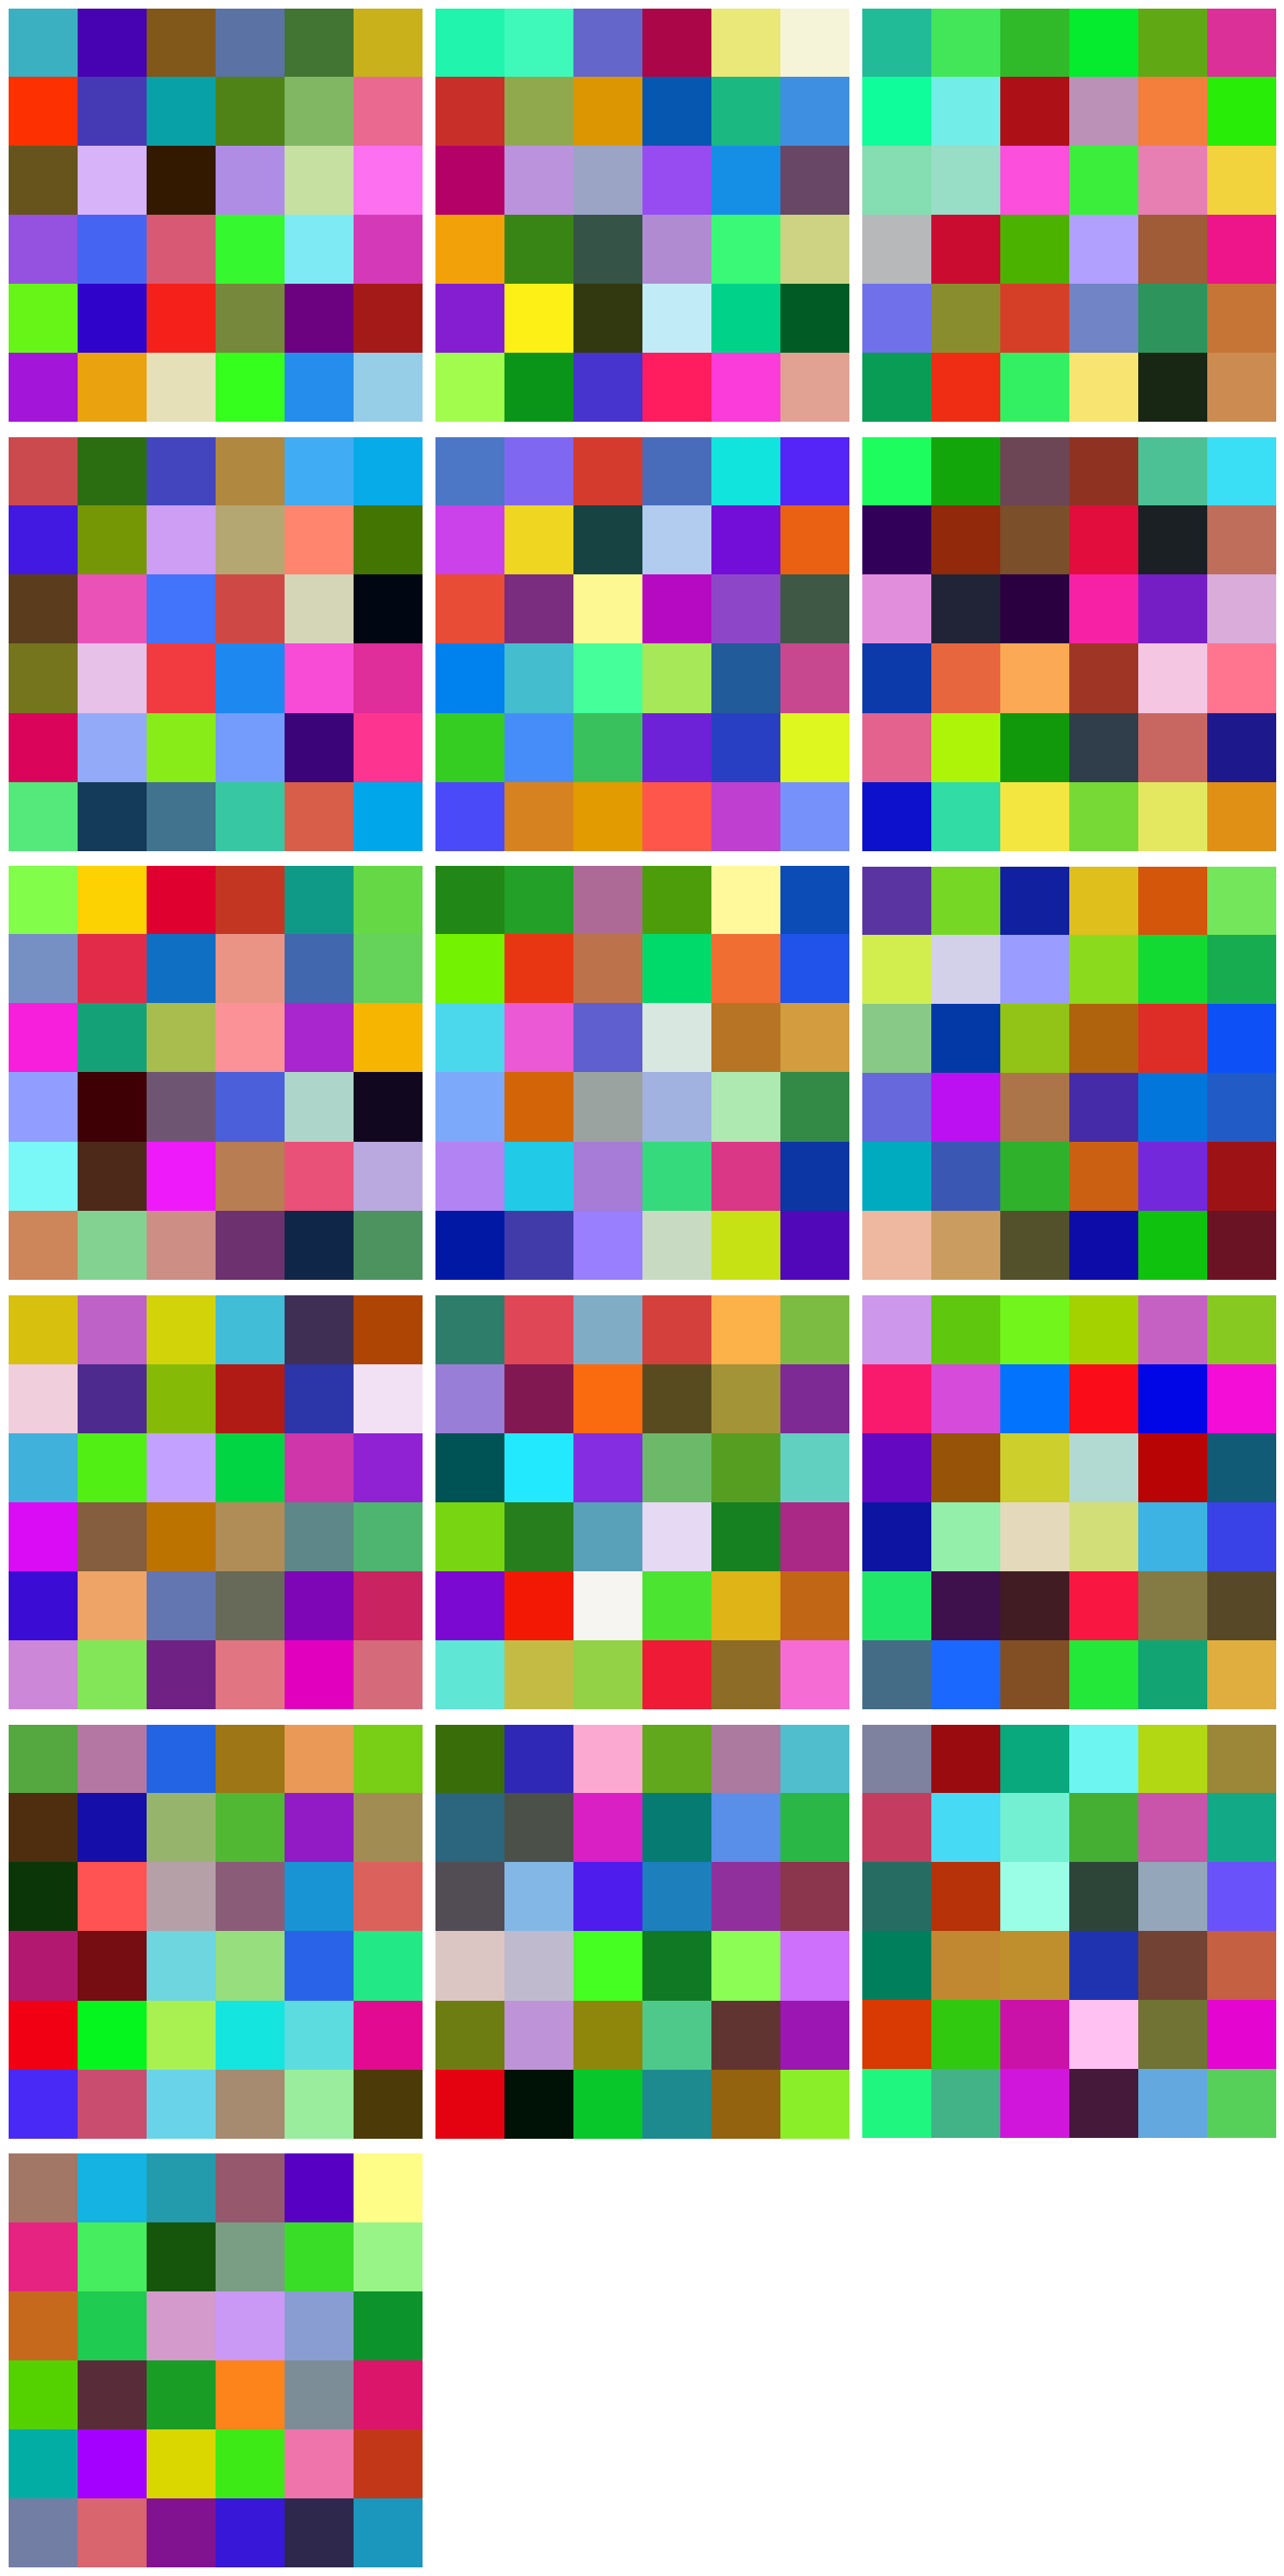

In [15]:
import numpy as np

# Change to model.path2_conv1.weight.data for second path
conv1wt = model.path1_conv1.weight.data
num_kernels = conv1wt.shape[0]

num_cols = 3
num_rows = (num_kernels + (num_cols - 1)) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for kernel in range(num_kernels):
    row_index = kernel // num_cols
    col_index = kernel % num_cols
    
    # Convert kernel to np array then standardize
    kernel_data = conv1wt[kernel].detach().cpu().numpy() 
    kernel_data = (kernel_data - np.min(kernel_data)) / (np.max(kernel_data) - np.min(kernel_data))
    
    # Display the kernel
    axes[row_index, col_index].imshow(kernel_data.transpose((1, 2, 0)))
    axes[row_index, col_index].axis('off')

# Hide any empty subplots
for i in range(num_kernels, num_rows * num_cols):
    row_index = i // num_cols
    col_index = i % num_cols
    fig.delaxes(axes[row_index, col_index])

plt.tight_layout()
plt.show()

Attribution using perterbations.

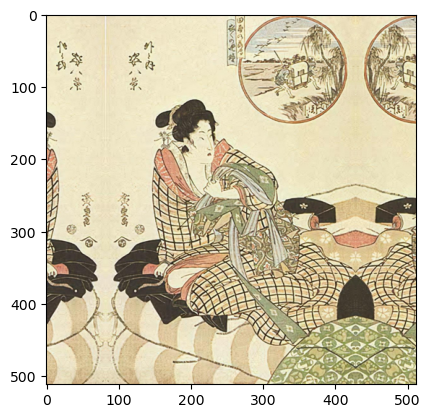

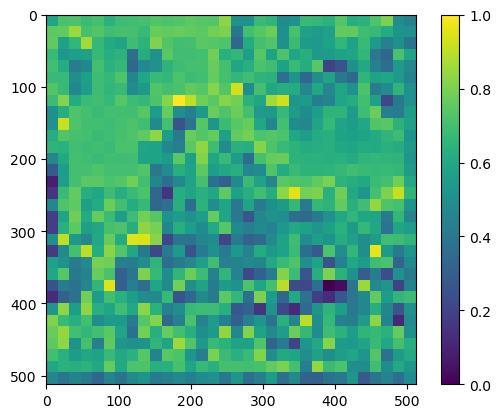

In [23]:
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

patch_size = 16
stride = 16 
img_dim = 512

# Load the image
image_path = "sampled_images/ukiyo_e2.jpeg"  # NOTE: Replace with the path to the image
image = Image.open(image_path).convert('RGB')

class SquarePad:
    def __call__(self, image):

        padded_tensor = torch.tensor(np.array(image), dtype=torch.float).permute(2,0,1)
        count = 0

        while padded_tensor.shape != (3, img_dim, img_dim):
            h = padded_tensor.shape[1]
            w = padded_tensor.shape[2]

            max_wh = max([w, h])
            hp = int((max_wh - w) // 2)
            vp = int((max_wh - h) // 2)
            padding = (hp, hp, vp, vp)
            if hp * 2 + w < img_dim:
                padding = (hp, hp + 1, vp, vp)
            if vp * 2 + h < img_dim:
                padding = (hp, hp, vp, vp + 1)

            padding = (min(padding[0], w-1),min(padding[1], w-1),min(padding[2], h-1),min(padding[3], h-1))

            padded_tensor = F.pad(padded_tensor,padding, mode='reflect')

        # Display the image after padding
        image_np = padded_tensor.permute(1, 2, 0).numpy()
        plt.imshow(image_np/255)
        plt.show()

        return padded_tensor

def custom_normalize(image_tensor):
    # Normalize image tensor to the range [0, 1]
    normalized_image = image_tensor / 255.0
    return normalized_image

def resize_larger_dimension(image, size):
    width, height = image.size
    aspect_ratio = width / height
    if width > height:
        new_width = size
        new_height = int(size / aspect_ratio)
    else:
        new_width = int(size * aspect_ratio)
        new_height = size

    return image.resize((new_width, new_height))

transform = transforms.Compose([
    transforms.Lambda(lambda x: resize_larger_dimension(x, img_dim)),  
    SquarePad(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

'''
GENERATED BY CHAT GPT
'''

# Apply transformations
image_tensor = transform(image)

# If needed, add an extra dimension to represent batch size
input_tensor = image_tensor.unsqueeze(0)

# Create an empty heatmap
heatmap = np.zeros((img_dim // stride, img_dim // stride))

# Slide the occlusion patch over the image and create the heatmap
for y in range(0, img_dim, stride):
    for x in range(0, img_dim, stride):
        # Create a copy of the input tensor to modify it
        occluded = input_tensor.clone()
        
        # Apply the occlusion patch
        # We set the pixels to 0 (black) within the occluded area
        occluded[:, :, y:y+patch_size, x:x+patch_size] = 0
        
        # Forward pass with the occluded image
        with torch.no_grad():
            occluded_output = model(occluded)
        
        # Use the probability of the correct class for the heatmap
        heatmap[y // stride, x // stride] = occluded_output[0, 3].item() # NOTE: Change second index to correct class

# Normalize the heatmap
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

# Display the heatmap
plt.imshow(heatmap, cmap='viridis', extent=[0, img_dim, img_dim, 0])
plt.colorbar()
plt.show()

Plot the losses.

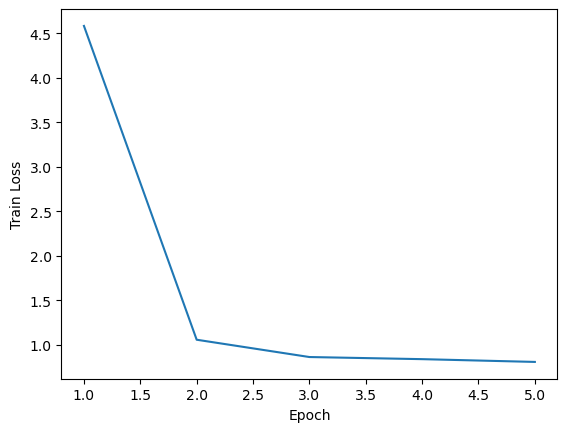

In [41]:
losses = [4.58109, 1.05707, 0.86276, 0.83895, 0.80785]

epochs = list(range(1, 6))
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.plot(epochs, losses)